### Pipeline ETL para Imagens Médicas DCE-MRI: Extração, Estruturação, Pré-Processamento e Análise Exploratória do Dataset Duke Breast Cancer MRI

**Objetivo:** criar um pipeline completo para manipular dados de ressonância magnética de mama (DCE-MRI) — baixar, organizar, ler DICOMs, integrar anotações, pré-processar e gerar estatísticas e visualizações.

**Etapas do Pipeline**

| **Etapa**                       | **Descrição**                                            | **Ferramentas / Arquivos**                       | **Exemplo de Código**                            |
| ------------------------------- | -------------------------------------------------------- | ------------------------------------------------ | ------------------------------------------------ |
| **1. Obtenção dos dados**       | Baixar imagens e anotações do TCIA                       | TCIA Downloader (NBIA) / `tcia_utils`            | `nbia.download_series()`                         |
| **2. Estrutura dos dados**      | Pastas com DICOMs por paciente + arquivos auxiliares     | `Annotation_Boxes.xlsx`, `file_path_mapping.csv` | `pd.read_excel("Annotation_Boxes.xlsx")`         |
| **3. Leitura dos DICOMs**       | Carregar imagens médicas em Python                       | `pydicom`, `matplotlib`                          | `ds = pydicom.dcmread(path)`                     |
| **4. Integração com anotações** | Usar bounding boxes do tumor (linhas, colunas, slices)   | `Annotation_Boxes.xlsx`                          | `row_start, col_start = ...`                     |
| **5. Pré-processamento**        | Normalização de intensidade, resample, seleção de séries | `numpy`, `nibabel`                               | `volume = ds.pixel_array / ds.pixel_array.max()` |
| **6. EDA – estatísticas**       | Número de pacientes, séries, volumes de tumor            | `pandas`, `matplotlib`                           | `annotations["tumor_volume"].hist()`             |
| **7. EDA – visualização**       | Exibir imagem + bounding box do tumor                    | `matplotlib.patches`                             | `ax.add_patch(rect)`                             |


### 1. Obtenção dos Dados (TCIA/NBIA API)

**Função:** conecta-se ao repositório NBIA (TCIA), obtém coleções, pacientes e séries, e baixa os DICOMs de um paciente da coleção Duke Breast Cancer MRI.
**Saída:** diretório `data/duke_mri/` contendo arquivos DICOM organizados por `SeriesInstanceUID`.

In [5]:
from nbiatoolkit import NBIAClient
import pandas as pd

# 1) Conectar ao NBIA
nbia = NBIAClient()

# 2) Obter coleções disponíveis
cols = nbia.getCollections(return_type="dataframe")
print(cols.query('Collection == "Duke-Breast-Cancer-MRI"'))

# 3) Obter pacientes da coleção
patients = nbia.getPatients(Collection="Duke-Breast-Cancer-MRI", return_type="dataframe")
print(patients.head())

# 4) Selecionar um paciente
pid = patients.loc[0, 'PatientId']

# 5) Buscar séries para o paciente selecionado
series = nbia.getSeries(Collection="Duke-Breast-Cancer-MRI",
                        PatientID=pid,
                        return_type="dataframe")

print(series[['SeriesInstanceUID', 'Modality', 'SeriesDescription']].head())

# 6) Selecionar um SeriesInstanceUID
uid = series.iloc[0]['SeriesInstanceUID']

# 7) Baixar a série para um diretório
nbia.downloadSeries(SeriesInstanceUID=uid, downloadDir="data/duke_mri")


                Collection
56  Duke-Breast-Cancer-MRI
        PatientId     PatientName PatientSex              Collection Phantom  \
0  Breast_MRI_001  Breast_MRI_001          F  Duke-Breast-Cancer-MRI      NO   
1  Breast_MRI_002  Breast_MRI_002        NaN  Duke-Breast-Cancer-MRI      NO   
2  Breast_MRI_005  Breast_MRI_005          F  Duke-Breast-Cancer-MRI      NO   
3  Breast_MRI_007  Breast_MRI_007          F  Duke-Breast-Cancer-MRI      NO   
4  Breast_MRI_009  Breast_MRI_009        NaN  Duke-Breast-Cancer-MRI      NO   

  SpeciesCode SpeciesDescription EthnicGroup  
0   337915000       Homo sapiens         NaN  
1   337915000       Homo sapiens         NaN  
2   337915000       Homo sapiens         NaN  
3   337915000       Homo sapiens         NaN  
4   337915000       Homo sapiens         NaN  
                                   SeriesInstanceUID Modality  \
0  1.3.6.1.4.1.14519.5.2.1.1072629657499780353316...       MR   
1  1.3.6.1.4.1.14519.5.2.1.1514720349923003958578... 

True

### 2. Estrutura dos dados

Lista pacientes, conta modalidades e constrói um resumo da coleção.

* Obtém a lista de pacientes e séries por paciente.
* Exibe modalidades (`T1`, `T2`, `DCE`, etc.).
* Cria um `DataFrame` `df_estrutura` com número de séries e modalidades por paciente.
* Serve como **verificação de integridade** antes da leitura dos DICOMs.

In [8]:
from nbiatoolkit import NBIAClient
import pandas as pd

nbia = NBIAClient()

# -----------------------------
# 2) Estrutura dos dados
# -----------------------------

# a) Lista de pacientes da coleção Duke
patients = nbia.getPatients(Collection="Duke-Breast-Cancer-MRI",
                            return_type="dataframe")
print(f"Total de pacientes: {len(patients)}")
print(patients.head())

# b) Selecionar um paciente de exemplo
pid = patients.loc[0, 'PatientId']
print(f"\nExemplo de PatientID: {pid}")

# c) Buscar todas as séries desse paciente
series = nbia.getSeries(Collection="Duke-Breast-Cancer-MRI",
                        PatientID=pid,
                        return_type="dataframe")

# d) Estrutura das séries
print("\nEstrutura das séries do paciente selecionado:")
print(series[['SeriesInstanceUID','Modality','SeriesDescription']].head())

# e) Quantas modalidades existem no dataset
modalidades = series['Modality'].value_counts()
print("\nDistribuição de modalidades:")
print(modalidades)

# f) Resumo geral da coleção (primeiros 10 pacientes)
estrutura = []
for p in patients['PatientId'][:10]:
    s = nbia.getSeries(Collection="Duke-Breast-Cancer-MRI",
                       PatientID=p,
                       return_type="dataframe")
    estrutura.append({
        "PatientID": p,
        "num_series": len(s),
        "modalidades": s['Modality'].unique().tolist()
    })

df_estrutura = pd.DataFrame(estrutura)
print("\nResumo de estrutura (amostra de 10 pacientes):")
print(df_estrutura)


Total de pacientes: 922
        PatientId     PatientName PatientSex              Collection Phantom  \
0  Breast_MRI_001  Breast_MRI_001          F  Duke-Breast-Cancer-MRI      NO   
1  Breast_MRI_002  Breast_MRI_002        NaN  Duke-Breast-Cancer-MRI      NO   
2  Breast_MRI_005  Breast_MRI_005          F  Duke-Breast-Cancer-MRI      NO   
3  Breast_MRI_007  Breast_MRI_007          F  Duke-Breast-Cancer-MRI      NO   
4  Breast_MRI_009  Breast_MRI_009        NaN  Duke-Breast-Cancer-MRI      NO   

  SpeciesCode SpeciesDescription EthnicGroup  
0   337915000       Homo sapiens         NaN  
1   337915000       Homo sapiens         NaN  
2   337915000       Homo sapiens         NaN  
3   337915000       Homo sapiens         NaN  
4   337915000       Homo sapiens         NaN  

Exemplo de PatientID: Breast_MRI_001

Estrutura das séries do paciente selecionado:
                                   SeriesInstanceUID Modality  \
0  1.3.6.1.4.1.14519.5.2.1.1072629657499780353316...       MR  

### 3. Leitura dos DICOMs

Usa `pydicom` para carregar imagens e validar integridade:

* Cria pastas para salvar os DICOMs.
* Faz *download* de cada série, tratando nomes e checando se há imagens.
* Função auxiliar `find_dicoms()` localiza arquivos `.dcm`.
**Objetivo:** garantir que os volumes estão prontos para leitura e reconstrução.

[INFO] Baixando 1.3.6.1.4.1.14519.5.2.1.107262965749978035331652357220510241458 ...
[INFO] downloadSeries retornou: True
[INFO] DICOMs encontrados: 160  (ex.: data\duke_mri\1.3.6.1.4.1.14519.5.2.1.107262965749978035331652357220510241458\41458\1.dcm)


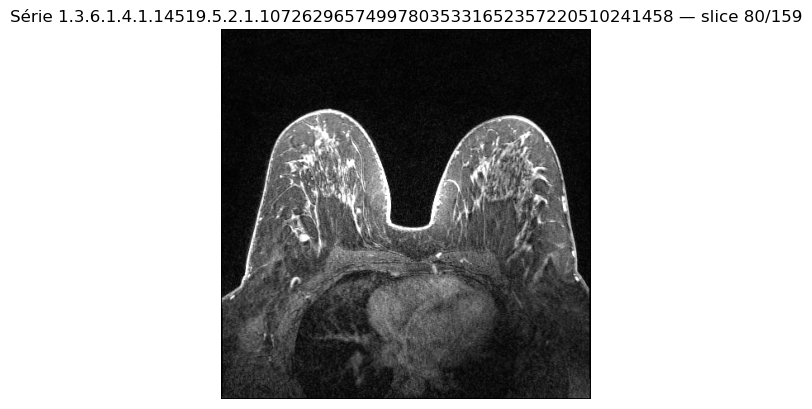

In [11]:
from nbiatoolkit import NBIAClient
import os, glob, numpy as np, pydicom, matplotlib.pyplot as plt

# Inicializa o cliente NBIA
nbia = NBIAClient()

# -----------------------------------------------------
# 1) Obter série válida (com imagens)
# -----------------------------------------------------
# Exemplo: series = nbia.getSeries(Collection="Duke-Breast-Cancer-MRI", PatientID=pid, return_type="dataframe")
# Certifique-se de definir `series` antes deste trecho
if 'series' not in locals() or series.empty:
    raise ValueError("A variável 'series' não está definida ou está vazia. Verifique a chamada ao getSeries().")

# Seleciona a primeira série
row = series.iloc[0]
uid = row['SeriesInstanceUID']

# Verifica se há imagens na série
if row.get('ImageCount', 1) == 0:
    raise SystemExit(f"Série sem imagens: {uid}")

from pathlib import Path
import requests, zipfile, io, time

# 2) Baixar DICOMs com padrão de nomes + checagens
base_dir = Path("data") / "duke_mri"
out_dir = base_dir / uid
out_dir.mkdir(parents=True, exist_ok=True)

print(f"[INFO] Baixando {uid} ...")
ret = nbia.downloadSeries(
    SeriesInstanceUID=uid,
    downloadDir=str(out_dir),
    filePattern='%SeriesInstanceUID/%InstanceNumber.dcm',
    overwrite=False,
    nParallel=5,
    Progressbar=True
)
print(f"[INFO] downloadSeries retornou: {ret}")

# 3) Buscar DICOMs ou ZIPs e fazer fallback
def find_dicoms(p):
    return sorted(p.rglob("*.dcm"))

dicom_files = find_dicoms(out_dir)

# Se o toolkit tiver salvo um ZIP, extraia
zip_candidates = list(out_dir.rglob("*.zip")) + list(out_dir.rglob("*.tcia"))
for zf in zip_candidates:
    try:
        with zipfile.ZipFile(zf, 'r') as z:
            z.extractall(out_dir / "extracted")
    except zipfile.BadZipFile:
        pass

if not dicom_files:
    dicom_files = find_dicoms(out_dir)

# Fallback REST v4 (TCIA) — 3 tentativas
if not dicom_files:
    print("[WARN] Nenhum .dcm encontrado após toolkit. Tentando REST v4 fallback...")
    url = f"https://services.cancerimagingarchive.net/services/v4/TCIA/query/getImage?SeriesInstanceUID={uid}"
    for attempt in range(3):
        try:
            r = requests.get(url, timeout=120)
            r.raise_for_status()
            with zipfile.ZipFile(io.BytesIO(r.content)) as z:
                z.extractall(out_dir / "rest_v4")
            break
        except Exception as e:
            print(f"[WARN] Tentativa {attempt+1}/3 falhou: {e}")
            time.sleep(2)
    dicom_files = find_dicoms(out_dir)

if not dicom_files:
    raise SystemExit(f"Nenhum DICOM após toolkit+fallback (verifique token/coleção/rede): {out_dir}")

print(f"[INFO] DICOMs encontrados: {len(dicom_files)}  (ex.: {dicom_files[0]})")


# -----------------------------------------------------
# 4) Ordenar slices e montar volume
# -----------------------------------------------------
def _inst_num(fp):
    try:
        return getattr(pydicom.dcmread(fp, stop_before_pixels=True), "InstanceNumber", 999999)
    except Exception:
        return 999999

# Ordena arquivos pela posição do slice
dicom_files.sort(key=_inst_num)

# Lê os arquivos DICOM e extrai os arrays de pixels
slices = [pydicom.dcmread(fp) for fp in dicom_files]
arrays = [s.pixel_array.astype(np.float32) for s in slices]
volume = np.stack(arrays, axis=0)  # Eixo 0: profundidade (slices)

# -----------------------------------------------------
# 5) Normalização robusta (entre percentis 1 e 99)
# -----------------------------------------------------
vmin, vmax = np.percentile(volume, [1, 99])
volume = np.clip(volume, vmin, vmax)
volume = (volume - vmin) / (vmax - vmin + 1e-8)

# -----------------------------------------------------
# 6) Visualização da slice do meio
# -----------------------------------------------------
mid = volume.shape[0] // 2
plt.imshow(volume[mid], cmap="gray")
plt.title(f"Série {uid} — slice {mid}/{volume.shape[0]-1}")
plt.axis("off")
plt.show()


### 4. Integração com anotações

Integra imagens com o arquivo `Annotation_Boxes.xlsx`.

Inclui:

* Funções para ler *metadata* dos DICOMs (`InstanceNumber`, `SliceLocation`, `PixelSpacing`, `SliceThickness`).
* Define caminhos e variáveis (`COLLECTION`, `DATA_DIR`, `ANN_XLSX`).
* Permite mapear coordenadas de *bounding boxes* sobre os volumes.
**Objetivo:** associar imagens médicas com marcações de lesões (tumores).

[INFO] Buscando pacientes...
[INFO] Total de pacientes: 922
[INFO] Paciente selecionado: Breast_MRI_001
[INFO] Buscando séries do paciente...
[INFO] Séries retornadas: 6, com imagens: 6
                                   SeriesInstanceUID Modality  \
0  1.3.6.1.4.1.14519.5.2.1.1072629657499780353316...       MR   
1  1.3.6.1.4.1.14519.5.2.1.1514720349923003958578...       MR   
2  1.3.6.1.4.1.14519.5.2.1.1754149663016455182384...       MR   
3  1.3.6.1.4.1.14519.5.2.1.1857778498036652445367...       MR   
4  1.3.6.1.4.1.14519.5.2.1.2992581698000354937472...       MR   

  SeriesDescription  
0   ax dyn 3rd pass  
1   ax dyn 1st pass  
2      ax t1 tse +c  
3        ax dyn pre  
4   ax dyn 4th pass  
[INFO] Série selecionada (UID): 1.3.6.1.4.1.14519.5.2.1.107262965749978035331652357220510241458
[INFO] Volume carregado: (160, 448, 448) — normalizado para [0,1]
[INFO] Voxel size (mm): dy=0.804, dx=0.804, dz=1.100


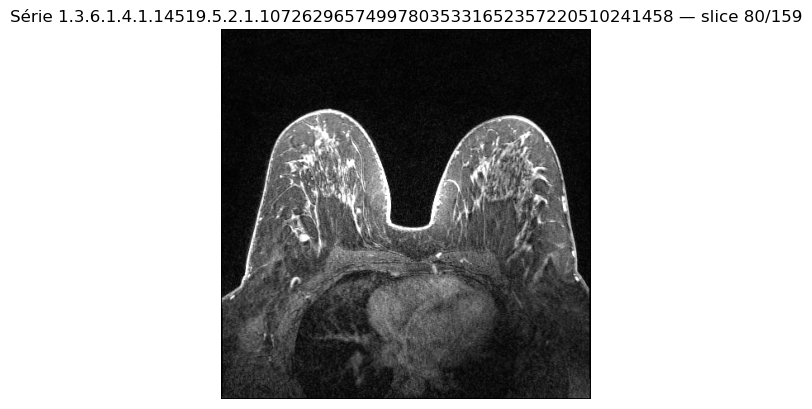

[AVISO] Planilha de anotações não encontrada: data\Annotation_Boxes.xlsx
        Pulei a integração (você ainda pode prosseguir com EDA/treino).


In [13]:
# -*- coding: utf-8 -*-
# Duke-Breast-Cancer-MRI — Etapas 2 (estrutura), 3 (leitura DICOMs) e 4 (integração com anotações)

import os, glob
import numpy as np
import pandas as pd
import pydicom
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from nbiatoolkit import NBIAClient

# =========================
# Configurações gerais
# =========================
COLLECTION = "Duke-Breast-Cancer-MRI"
DATA_DIR   = "data"
DL_BASE    = os.path.join(DATA_DIR, "duke_mri")          # onde baixam os DICOMs
ANN_XLSX   = os.path.join(DATA_DIR, "Annotation_Boxes.xlsx")  # planilha de anotações (opcional)
os.makedirs(DL_BASE, exist_ok=True)

# =========================
# Utilidades
# =========================
def safe_instance_number(fp):
    try:
        ds = pydicom.dcmread(fp, stop_before_pixels=True)
        return getattr(ds, "InstanceNumber", None)
    except Exception:
        return None

def safe_slice_location(fp):
    try:
        ds = pydicom.dcmread(fp, stop_before_pixels=True)
        return getattr(ds, "SliceLocation", None)
    except Exception:
        return None

def get_spacing_from_slice(ds):
    """Retorna (dy, dx, dz) em mm (PixelSpacing + SliceThickness) se existirem; senão (1,1,1)."""
    try:
        dy, dx = [float(x) for x in getattr(ds, "PixelSpacing", [1.0, 1.0])]
    except Exception:
        dy, dx = 1.0, 1.0
    try:
        dz = float(getattr(ds, "SliceThickness", 1.0))
    except Exception:
        dz = 1.0
    return dy, dx, dz

def clamp(v, vmin, vmax):
    return int(max(vmin, min(int(v), vmax)))

def crop_bbox(volume, r0, r1, c0, c1, z0, z1):
    """Valida limites e retorna recorte [z, y, x] + limites corrigidos."""
    Z, Y, X = volume.shape
    r0c = clamp(r0, 0, Y-1); r1c = clamp(r1, 0, Y-1)
    c0c = clamp(c0, 0, X-1); c1c = clamp(c1, 0, X-1)
    z0c = clamp(z0, 0, Z-1); z1c = clamp(z1, 0, Z-1)
    if r1c < r0c: r0c, r1c = r1c, r0c
    if c1c < c0c: c0c, c1c = c1c, c0c
    if z1c < z0c: z0c, z1c = z1c, z0c
    crop = volume[z0c:z1c+1, r0c:r1c+1, c0c:c1c+1]
    return crop, (r0c, r1c, c0c, c1c, z0c, z1c)

def find_dicoms(out_dir):
    """Busca DICOMs recursivamente. Se não achar .dcm, tenta detectar DICOMs sem extensão."""
    dicom_files = sorted(glob.glob(os.path.join(out_dir, "**", "*.dcm"), recursive=True))
    if dicom_files:
        return dicom_files

    # fallback: detectar DICOMs sem extensão
    any_files = sorted(glob.glob(os.path.join(out_dir, "**", "*"), recursive=True))
    any_files = [f for f in any_files if os.path.isfile(f)]
    detected = []
    for fp in any_files:
        try:
            pydicom.dcmread(fp, stop_before_pixels=True, force=True)
            detected.append(fp)
        except Exception:
            pass
    return sorted(detected)

def load_volume_from_dir(out_dir):
    """Lê todos os DICOMs do diretório em um volume 3D normalizado (0-1) + metadados."""
    dicom_files = find_dicoms(out_dir)
    if not dicom_files:
        raise SystemExit(f"Nenhum DICOM encontrado em: {out_dir}")

    # Ordenar por InstanceNumber, depois SliceLocation, senão ordem do filesystem
    headers = [pydicom.dcmread(fp, stop_before_pixels=True) for fp in dicom_files]
    if all(getattr(h, "InstanceNumber", None) is not None for h in headers):
        order = np.argsort([int(h.InstanceNumber) for h in headers])
    elif all(getattr(h, "SliceLocation", None) is not None for h in headers):
        order = np.argsort([float(h.SliceLocation) for h in headers])
    else:
        order = np.arange(len(headers))
    dicom_files = [dicom_files[i] for i in order]

    slices = [pydicom.dcmread(fp) for fp in dicom_files]
    arrays = [s.pixel_array.astype(np.float32) for s in slices]
    volume = np.stack(arrays, axis=0)  # (Z, Y, X)

    # Normalização robusta (1-99 percentis)
    vmin, vmax = np.percentile(volume, [1, 99])
    volume = np.clip(volume, vmin, vmax)
    volume = (volume - vmin) / (vmax - vmin + 1e-8)

    # Spacing e PatientID
    dy, dx, dz = get_spacing_from_slice(slices[0])
    patient_id = getattr(slices[0], "PatientID", None)

    return volume, (dy, dx, dz), patient_id, slices

# =========================
# 2) Estrutura dos dados
# =========================
nbia = NBIAClient()

print("[INFO] Buscando pacientes...")
patients = nbia.getPatients(Collection=COLLECTION, return_type="dataframe")
print(f"[INFO] Total de pacientes: {len(patients)}")

# Seleciona um paciente de exemplo (troque o índice se quiser)
pid = patients.loc[0, "PatientId"]
print(f"[INFO] Paciente selecionado: {pid}")

print("[INFO] Buscando séries do paciente...")
series = nbia.getSeries(Collection=COLLECTION, PatientID=pid, return_type="dataframe")

# filtra séries com ImageCount > 0 (se a coluna existir)
if "ImageCount" in series.columns:
    series_ok = series[series["ImageCount"].fillna(0).astype(int) > 0].copy()
    if series_ok.empty:
        raise SystemExit("Nenhuma série com imagens para este paciente.")
else:
    series_ok = series.copy()  # se não houver coluna, segue com todas

print(f"[INFO] Séries retornadas: {len(series)}, com imagens: {len(series_ok)}")
print(series_ok[['SeriesInstanceUID','Modality','SeriesDescription']].head())

# Escolher a primeira série válida (ajuste conforme necessário)
uid = series_ok.iloc[0]["SeriesInstanceUID"]
print(f"[INFO] Série selecionada (UID): {uid}")

# =========================
# 3) Leitura dos DICOMs
# =========================
out_dir = os.path.join(DL_BASE, str(uid))
os.makedirs(out_dir, exist_ok=True)

# Força um padrão com extensão .dcm para facilitar o glob
if not find_dicoms(out_dir):
    print(f"[INFO] Baixando série {uid} para {out_dir} ...")
    nbia.downloadSeries(
        SeriesInstanceUID=str(uid),
        downloadDir=out_dir,
        filePattern='%SeriesInstanceUID/%InstanceNumber.dcm'
    )

# Carrega volume
volume_norm, (dy, dx, dz), patient_id_dcm, slices = load_volume_from_dir(out_dir)
print(f"[INFO] Volume carregado: {volume_norm.shape} — normalizado para [0,1]")
print(f"[INFO] Voxel size (mm): dy={dy:.3f}, dx={dx:.3f}, dz={dz:.3f}")
mid = volume_norm.shape[0] // 2
plt.imshow(volume_norm[mid], cmap="gray")
plt.title(f"Série {uid} — slice {mid}/{volume_norm.shape[0]-1}")
plt.axis("off")
plt.show()

# =========================
# 4) Integração com anotações (opcional)
# =========================
if not os.path.exists(ANN_XLSX):
    print(f"[AVISO] Planilha de anotações não encontrada: {ANN_XLSX}")
    print("        Pulei a integração (você ainda pode prosseguir com EDA/treino).")
else:
    print("[INFO] Lendo planilha de anotações...")
    ann_raw = pd.read_excel(ANN_XLSX)
    ann = ann_raw.copy()
    ann.columns = [str(c).strip().lower() for c in ann.columns]

    # detectar nomes prováveis de colunas de identificação
    col_uid = "seriesinstanceuid" if "seriesinstanceuid" in ann.columns else ("series_uid" if "series_uid" in ann.columns else None)
    col_pid = "patientid" if "patientid" in ann.columns else ("patient_id" if "patient_id" in ann.columns else None)

    required = ["row_start","row_end","col_start","col_end","slice_start","slice_end"]
    for req in required:
        if req not in ann.columns:
            raise SystemExit(f"Coluna obrigatória '{req}' ausente nas anotações. Colunas: {list(ann.columns)}")

    # tenta casar por UID; fallback por PatientID do DICOM
    subset = pd.DataFrame()
    if col_uid and col_uid in ann.columns:
        subset = ann[ann[col_uid].astype(str) == str(uid)]

    if subset.empty and col_pid and patient_id_dcm is not None:
        subset = ann[ann[col_pid].astype(str) == str(patient_id_dcm)]

    if subset.empty:
        print("[AVISO] Não há anotações compatíveis para esta série/paciente.")
    else:
        subset = subset.reset_index(drop=True)
        print(f"[INFO] {len(subset)} anotação(ões) encontrada(s) para a série/paciente.")

        # Preparar pasta de saída dos crops
        crops_dir = os.path.join(DATA_DIR, "duke_mri_crops", str(uid))
        os.makedirs(crops_dir, exist_ok=True)

        rows = []
        for i, row in subset.iterrows():
            r0, r1 = int(row["row_start"]),   int(row["row_end"])
            c0, c1 = int(row["col_start"]),   int(row["col_end"])
            z0, z1 = int(row["slice_start"]), int(row["slice_end"])

            crop, (r0c, r1c, c0c, c1c, z0c, z1c) = crop_bbox(volume_norm, r0, r1, c0, c1, z0, z1)
            vz, vy, vx = crop.shape
            voxels = int(vz * vy * vx)
            vol_mm3 = voxels * (dy * dx * dz)

            crop_name = f"lesion_{i:02d}_z{z0c}-{z1c}_r{r0c}-{r1c}_c{c0c}-{c1c}.npy"
            crop_path = os.path.join(crops_dir, crop_name)
            np.save(crop_path, crop)

            rows.append({
                "SeriesInstanceUID": str(uid),
                "PatientID": str(patient_id_dcm),
                "lesion_idx": i,
                "r0": r0c, "r1": r1c,
                "c0": c0c, "c1": c1c,
                "z0": z0c, "z1": z1c,
                "crop_path": crop_path,
                "voxels": voxels,
                "voxel_size_mm": f"{dy:.3f}×{dx:.3f}×{dz:.3f}",
                "volume_mm3": vol_mm3
            })

        df_crops = pd.DataFrame(rows)
        csv_out = os.path.join(crops_dir, "crops_summary.csv")
        df_crops.to_csv(csv_out, index=False, encoding="utf-8")
        print(f"[INFO] {len(df_crops)} recorte(s) salvo(s) em: {crops_dir}")
        print(f"[INFO] Resumo salvo em: {csv_out}")
        display(df_crops.head())

        # Visualização rápida da primeira lesão
        if len(df_crops) > 0:
            r0c, r1c = df_crops.loc[0, ["r0","r1"]]
            c0c, c1c = df_crops.loc[0, ["c0","c1"]]
            z0c, z1c = df_crops.loc[0, ["z0","z1"]]
            zc = int((z0c + z1c) // 2)

            fig, ax = plt.subplots()
            ax.imshow(volume_norm[zc], cmap="gray")
            rect = patches.Rectangle((c0c, r0c), c1c - c0c, r1c - r0c,
                                     linewidth=2, edgecolor="r", facecolor="none")
            ax.add_patch(rect)
            ax.set_title(f"Lesão 0 — slice {zc} (z∈[{z0c},{z1c}])")
            ax.axis("off")
            plt.show()


### 5. Pré-processamento

Define funções para *resample* e normalização:

* `resample_volume_ndimage`: usa `scipy.ndimage.zoom` para redimensionar voxels 3D.
* `resample_volume_sitk`: usa `SimpleITK` com interpolação linear ou spline.
* Padroniza resolução para `(1.0, 1.0, 1.0)` mm.
**Etapa crucial** para alinhar volumes de diferentes scanners antes de modelos ML.


[INFO] Pré-processando volume completo...
[INFO] Salvo: data\duke_mri_preproc\series_1.3.6.1.4.1.14519.5.2.1.107262965749978035331652357220510241458_preproc_iso1.0mm.npy e data\duke_mri_preproc\series_1.3.6.1.4.1.14519.5.2.1.107262965749978035331652357220510241458_preproc_iso1.0mm.nii.gz


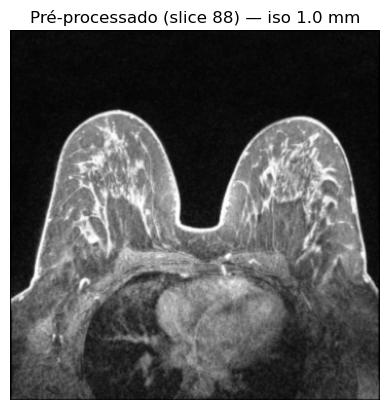

In [15]:
# 5) Pré-processamento — resample, N4 bias, denoise, normalização e salvamento

import os
import numpy as np

# ----------------------------------------
# 5.1 Funções utilitárias
# ----------------------------------------
def resample_volume_ndimage(volume, spacing_xyz, target_spacing=(1.0, 1.0, 1.0), order=1):
    """
    Resample 3D com scipy.ndimage.zoom (order=1 bilinear/tri).
    spacing_xyz = (dz, dy, dx) em mm
    target_spacing = (1,1,1) mm por padrão
    """
    try:
        from scipy.ndimage import zoom
    except Exception as e:
        raise RuntimeError("É necessário scipy para resample via ndimage.zoom.") from e

    dz, dy, dx = spacing_xyz
    tz, ty, tx = target_spacing

    # fatores = tamanho_antigo / tamanho_novo = spacing_atual / spacing_alvo
    # zoom usa fatores diretamente sobre shape → fator = dz/tz para eixo Z, etc.
    zoom_factors = (dz / tz, dy / ty, dx / tx)
    vol_res = zoom(volume, zoom=zoom_factors, order=order, mode="nearest")
    return vol_res

def resample_volume_sitk(volume, spacing_xyz, target_spacing=(1.0, 1.0, 1.0), interp="linear"):
    """
    Resample 3D com SimpleITK (se disponível).
    spacing_xyz = (dz, dy, dx). SimpleITK usa (dx, dy, dz) → vamos converter.
    """
    try:
        import SimpleITK as sitk
    except Exception as e:
        raise RuntimeError("SimpleITK não disponível para resample Spline/N4.") from e

    dz, dy, dx = spacing_xyz
    tz, ty, tx = target_spacing

    # cria imagem SITK com ordem (x,y,z)
    img = sitk.GetImageFromArray(volume)  # array (z,y,x)
    img.SetSpacing((dx, dy, dz))

    # novo tamanho: round( old_size * (old_spacing / new_spacing) )
    old_size = np.array(list(img.GetSize())[::-1])  # (z,y,x) do numpy
    old_spacing = np.array([dz, dy, dx])
    new_spacing = np.array([tz, ty, tx])
    new_size_zyx = np.round(old_size * (old_spacing / new_spacing)).astype(int)

    # configurar interpolador
    interp_map = {"nearest": sitk.sitkNearestNeighbor,
                  "linear": sitk.sitkLinear,
                  "bspline": sitk.sitkBSpline}
    itp = interp_map.get(interp, sitk.sitkLinear)

    res = sitk.Resample(img,
                        size=[int(new_size_zyx[2]), int(new_size_zyx[1]), int(new_size_zyx[0])],
                        transform=sitk.Transform(),
                        interpolator=itp,
                        outputSpacing=(tx, ty, tz),
                        outputOrigin=img.GetOrigin(),
                        outputDirection=img.GetDirection(),
                        defaultPixelValue=0.0)

    return sitk.GetArrayFromImage(res)  # volta (z,y,x)

def n4_bias_correction(volume, spacing_xyz):
    """
    N4ITK bias field correction 3D (opcional).
    Se SimpleITK não estiver disponível, retorna o volume original.
    """
    try:
        import SimpleITK as sitk
    except Exception:
        # fallback: sem correção
        return volume

    dz, dy, dx = spacing_xyz
    img = sitk.GetImageFromArray(volume.astype(np.float32))
    img.SetSpacing((dx, dy, dz))
    # máscara por Otsu para focar em tecido
    mask = sitk.OtsuThreshold(img, 0, 1)

    corrector = sitk.N4BiasFieldCorrectionImageFilter()
    # parâmetros padrão costumam ser OK; pode ajustar se quiser
    out = corrector.Execute(img, mask)
    vol_corr = sitk.GetArrayFromImage(out)
    # reescalar para [0,1] por segurança
    p1, p99 = np.percentile(vol_corr, [1, 99])
    vol_corr = np.clip(vol_corr, p1, p99)
    vol_corr = (vol_corr - p1) / (p99 - p1 + 1e-8)
    return vol_corr

def gaussian_denoise(volume, sigma=0.5):
    """Denoise com Gaussian 3D (scipy)."""
    try:
        from scipy.ndimage import gaussian_filter
    except Exception as e:
        raise RuntimeError("É necessário scipy para gaussian_filter.") from e
    return gaussian_filter(volume, sigma=sigma)

def zscore_norm(volume, use_otsu=True):
    """
    Normalização z-score:
    - Se use_otsu=True, calcula média/desvio apenas numa máscara Otsu para evitar fundo/artefatos.
    - Caso contrário, usa o volume todo.
    """
    if use_otsu:
        try:
            from skimage.filters import threshold_otsu
            thr = threshold_otsu(volume.astype(np.float32))
            mask = volume > thr
            if mask.sum() < 50:  # proteção para volumes vazios
                mask = volume > np.percentile(volume, 70)
        except Exception:
            # fallback: percentil
            mask = volume > np.percentile(volume, 70)
    else:
        mask = np.ones_like(volume, dtype=bool)

    mu = float(volume[mask].mean())
    sd = float(volume[mask].std() + 1e-8)
    v = (volume - mu) / sd
    # opcional: clipe para faixa padrão
    v = np.clip(v, -5.0, 5.0)
    # reescala para [0,1] se preferir manter intensidade positiva
    v = (v - v.min()) / (v.max() - v.min() + 1e-8)
    return v

def save_outputs(volume, spacing_xyz, out_prefix):
    """
    Salva .npy e (se disponível) NIfTI (.nii.gz).
    spacing_xyz = (dz, dy, dx) em mm.
    """
    npy_path = f"{out_prefix}.npy"
    np.save(npy_path, volume.astype(np.float32))

    # NIfTI opcional
    try:
        import nibabel as nib
        dz, dy, dx = spacing_xyz
        # affine simples (diagonal) — ajuste se precisar respeitar orientação real
        affine = np.diag([dx, dy, dz, 1.0])
        img = nib.Nifti1Image(volume.astype(np.float32), affine)
        nii_path = f"{out_prefix}.nii.gz"
        nib.save(img, nii_path)
        return npy_path, nii_path
    except Exception:
        return npy_path, None

# ----------------------------------------
# 5.2 Pipeline de pré-processamento (Volume inteiro)
# ----------------------------------------
TARGET_SPACING = (1.0, 1.0, 1.0)  # (dz, dy, dx) isotrópico, mude se quiser 0.8mm, p.ex.
OUT_PRE_DIR = os.path.join("data", "duke_mri_preproc")
os.makedirs(OUT_PRE_DIR, exist_ok=True)

print("[INFO] Pré-processando volume completo...")

vol_in = volume_norm.copy()
spacing_in = (dz, dy, dx)  # da Etapa 3

# (A) Resample para voxel isotrópico
try:
    # preferir SITK se disponível (melhor interpolação/opções)
    vol_rs = resample_volume_sitk(vol_in, spacing_in, target_spacing=TARGET_SPACING, interp="linear")
except Exception:
    vol_rs = resample_volume_ndimage(vol_in, spacing_in, target_spacing=TARGET_SPACING, order=1)

# (B) Correção de bias (N4) — opcional, roda só se SimpleITK estiver disponível
vol_n4 = n4_bias_correction(vol_rs, TARGET_SPACING)

# (C) Denoise leve
vol_dn = gaussian_denoise(vol_n4, sigma=0.6)

# (D) Normalização final (z-score com máscara)
vol_pp = zscore_norm(vol_dn, use_otsu=True)

# Salvar
prefix = os.path.join(OUT_PRE_DIR, f"series_{str(uid)}_preproc_iso{TARGET_SPACING[0]:.1f}mm")
npy_path, nii_path = save_outputs(vol_pp, TARGET_SPACING, prefix)
print(f"[INFO] Salvo: {npy_path}" + (f" e {nii_path}" if nii_path else ""))

# Visual rápido
mid = vol_pp.shape[0] // 2
import matplotlib.pyplot as plt
plt.imshow(vol_pp[mid], cmap="gray")
plt.title(f"Pré-processado (slice {mid}) — iso {TARGET_SPACING[0]} mm")
plt.axis("off"); plt.show()

# ----------------------------------------
# 5.3 (Opcional) Pré-processar também os CROPS (Etapa 4)
#     Se df_crops existir, aplica pipeline reduzido por recorte
# ----------------------------------------
if "df_crops" in globals() and not df_crops.empty:
    OUT_CROP_PRE = os.path.join("data", "duke_mri_crops_preproc", str(uid))
    os.makedirs(OUT_CROP_PRE, exist_ok=True)
    rows_pp = []
    print(f"[INFO] Pré-processando {len(df_crops)} crop(s)...")

    for _, r in df_crops.iterrows():
        crop = np.load(r["crop_path"])
        # crops já estão normalizados (vieram de volume_norm), mas vamos padronizar também:

        # Opcional: resample dos crops até tamanho fixo (ex.: 64×128×128) PARA TREINO
        # Aqui vou só aplicar denoise+zscore para manter forma original do crop:
        crop_dn = gaussian_denoise(crop, sigma=0.5)
        crop_pp = zscore_norm(crop_dn, use_otsu=True)

        # salvar
        name = os.path.splitext(os.path.basename(r["crop_path"]))[0]
        outp = os.path.join(OUT_CROP_PRE, f"{name}_pp.npy")
        np.save(outp, crop_pp.astype(np.float32))

        rows_pp.append({
            **r.to_dict(),
            "crop_pp_path": outp
        })

    df_crops_pp = pd.DataFrame(rows_pp)
    out_csv = os.path.join(OUT_CROP_PRE, "crops_preproc_summary.csv")
    df_crops_pp.to_csv(out_csv, index=False, encoding="utf-8")
    print(f"[INFO] Crops pré-processados salvos em: {OUT_CROP_PRE}")


### 6. EDA – estatísticas

Gera métricas descritivas:

* Conta pacientes, séries por paciente, modalidades.
* Usa `matplotlib` e `seaborn` para plotar histogramas e barras.
* Se existir `df_crops`, analisa número de lesões por paciente.

**Insight:** mostra distribuição e consistência do dataset, útil para planejamento de treino.


[EDA] Pacientes únicos: 922
[EDA] Média de séries por paciente: 6.00
count    1.0
mean     6.0
std      NaN
min      6.0
25%      6.0
50%      6.0
75%      6.0
max      6.0
Name: SeriesInstanceUID, dtype: float64


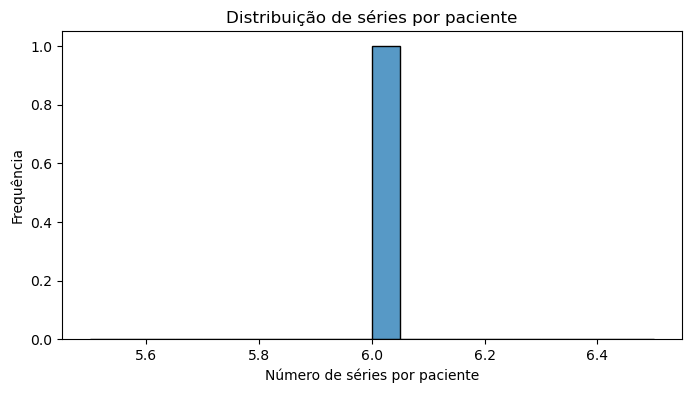


[EDA] Distribuição de modalidades:
Modality
MR    6
Name: count, dtype: int64


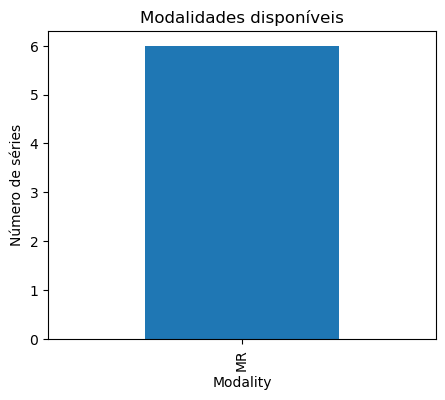


[EDA] Principais descrições de séries:
SeriesDescription
ax dyn 3rd pass    1
ax dyn 1st pass    1
ax t1 tse +c       1
ax dyn pre         1
ax dyn 4th pass    1
ax dyn 2nd pass    1
Name: count, dtype: int64

[EDA] Nenhuma anotação/crop disponível — pulei estatísticas de lesões.


In [17]:
# 6) EDA — Estatísticas do Duke Breast MRI

import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 6.1 Estatísticas de pacientes
# -----------------------------
print(f"[EDA] Pacientes únicos: {patients['PatientId'].nunique()}")

# número de séries por paciente
series_per_patient = series_ok.groupby("PatientID")["SeriesInstanceUID"].count()
print(f"[EDA] Média de séries por paciente: {series_per_patient.mean():.2f}")
print(series_per_patient.describe())

plt.figure(figsize=(8,4))
sns.histplot(series_per_patient, bins=20, kde=False)
plt.xlabel("Número de séries por paciente")
plt.ylabel("Frequência")
plt.title("Distribuição de séries por paciente")
plt.show()

# -----------------------------
# 6.2 Modalidades e descrições
# -----------------------------
print("\n[EDA] Distribuição de modalidades:")
print(series_ok["Modality"].value_counts())

plt.figure(figsize=(5,4))
series_ok["Modality"].value_counts().plot(kind="bar")
plt.title("Modalidades disponíveis")
plt.ylabel("Número de séries")
plt.show()

if "SeriesDescription" in series_ok.columns:
    print("\n[EDA] Principais descrições de séries:")
    print(series_ok["SeriesDescription"].value_counts().head(10))

# -----------------------------
# 6.3 Estatísticas de crops (lesões) — se df_crops existir
# -----------------------------
if "df_crops" in globals() and not df_crops.empty:
    print(f"\n[EDA] Número total de lesões anotadas: {len(df_crops)}")
    print(f"[EDA] Lesões por paciente (média): {df_crops.groupby('PatientID')['lesion_idx'].count().mean():.2f}")

    # histograma de volumes em voxels
    plt.figure(figsize=(8,4))
    sns.histplot(df_crops["voxels"], bins=40, log_scale=True)
    plt.xlabel("Voxels por lesão (log)")
    plt.ylabel("Frequência")
    plt.title("Distribuição de tamanhos de lesão (voxels)")
    plt.show()

    # histograma de volumes em mm³
    plt.figure(figsize=(8,4))
    sns.histplot(df_crops["volume_mm3"], bins=40, log_scale=True)
    plt.xlabel("Volume da lesão (mm³, log)")
    plt.ylabel("Frequência")
    plt.title("Distribuição de volumes tumorais (mm³)")
    plt.show()

    # boxplot comparando volumes por paciente (amostra até 20 pacientes)
    top_pats = df_crops["PatientID"].value_counts().head(20).index
    plt.figure(figsize=(12,5))
    sns.boxplot(data=df_crops[df_crops["PatientID"].isin(top_pats)],
                x="PatientID", y="volume_mm3")
    plt.xticks(rotation=90)
    plt.yscale("log")
    plt.ylabel("Volume da lesão (mm³, escala log)")
    plt.title("Volumes tumorais — top 20 pacientes com mais lesões")
    plt.show()
else:
    print("\n[EDA] Nenhuma anotação/crop disponível — pulei estatísticas de lesões.")


### 7. EDA – visualização

Implementa `show_slices()` para exibir cortes axiais, coronais e sagitais do volume 3D:

* Mostra cortes centrais do volume pré-processado (`vol_pp`).
* Se há anotações (`df_crops`), exibe exemplos de *bounding boxes*.

**Função:** verificar visualmente a qualidade dos dados e anotações antes do modelamento.


[EDA-Vis] Visualizando cortes centrais do volume pré-processado...


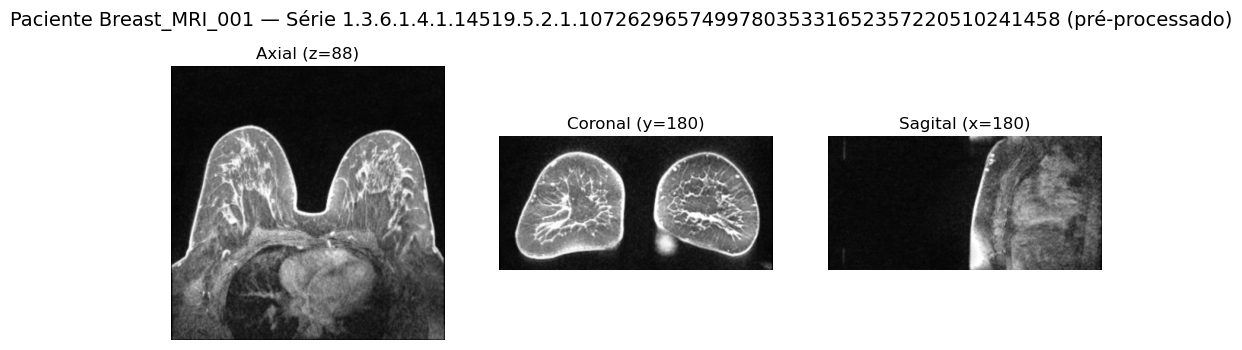

In [19]:
# 7) EDA — Visualização de exemplos

import matplotlib.pyplot as plt
import numpy as np
import random

# -----------------------------
# 7.1 Função para mostrar fatias ortogonais (Z, Y, X)
# -----------------------------
def show_slices(volume, title=""):
    """Mostra cortes axiais, coronais e sagitais do volume 3D."""
    zc, yc, xc = np.array(volume.shape) // 2
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(volume[zc], cmap="gray")     # corte axial (Z fixo)
    axes[0].set_title(f"Axial (z={zc})")
    axes[0].axis("off")

    axes[1].imshow(volume[:, yc, :], cmap="gray")  # corte coronal (Y fixo)
    axes[1].set_title(f"Coronal (y={yc})")
    axes[1].axis("off")

    axes[2].imshow(volume[:, :, xc], cmap="gray")  # corte sagital (X fixo)
    axes[2].set_title(f"Sagital (x={xc})")
    axes[2].axis("off")

    fig.suptitle(title, fontsize=14)
    plt.show()

# -----------------------------
# 7.2 Visualizar volume completo (um paciente)
# -----------------------------
print("[EDA-Vis] Visualizando cortes centrais do volume pré-processado...")
show_slices(vol_pp, title=f"Paciente {patient_id_dcm} — Série {uid} (pré-processado)")

# -----------------------------
# 7.3 Exemplo de lesões com bounding box
# -----------------------------
if "df_crops" in globals() and not df_crops.empty:
    print("[EDA-Vis] Visualizando algumas lesões com bounding box...")

    sample_lesions = df_crops.sample(min(3, len(df_crops)), random_state=42)  # até 3 lesões aleatórias
    for _, row in sample_lesions.iterrows():
        r0, r1 = int(row["r0"]), int(row["r1"])
        c0, c1 = int(row["c0"]), int(row["c1"])
        z0, z1 = int(row["z0"]), int(row["z1"])
        zc = (z0 + z1) // 2

        fig, ax = plt.subplots(figsize=(5,5))
        ax.imshow(volume_norm[zc], cmap="gray")
        rect = plt.Rectangle((c0, r0), c1 - c0, r1 - r0,
                             edgecolor="red", facecolor="none", linewidth=2)
        ax.add_patch(rect)
        ax.set_title(f"Lesão — slice {zc} | Paciente {row['PatientID']}")
        ax.axis("off")
        plt.show()

# -----------------------------
# 7.4 Visualizar crops (recortes 3D de tumores)
# -----------------------------
if "df_crops" in globals() and not df_crops.empty:
    print("[EDA-Vis] Visualizando recortes 3D de lesões...")

    sample_crops = df_crops.sample(min(2, len(df_crops)), random_state=7)  # até 2 crops
    for _, row in sample_crops.iterrows():
        crop = np.load(row["crop_path"])
        show_slices(crop, title=f"Crop da lesão {row['lesion_idx']} (Paciente {row['PatientID']})")


### Conclusão

O notebook `etl_basico.ipynb` implementa um **pipeline completo para imagens médicas (DICOM)** do *Duke Breast Cancer MRI*, com sete etapas:

1. **Extração** – baixar dados do TCIA
2. **Estruturação** – organizar pacientes/séries
3. **Leitura** – validar e carregar DICOMs
4. **Integração** – cruzar com anotações
5. **Transformação** – *resample*, normalização, limpeza
6. **Análise Estatística** – distribuições e contagens
7. **Visualização** – cortes 3D e *bounding boxes*

